In [1]:
import kagglehub
awsaf49_brats2020_training_data_path = kagglehub.dataset_download('awsaf49/brats2020-training-data')
awsaf49_brats20_dataset_training_validation_path = kagglehub.dataset_download('awsaf49/brats20-dataset-training-validation')
aryashah2k_brain_tumor_segmentation_brats_2019_path = kagglehub.dataset_download('aryashah2k/brain-tumor-segmentation-brats-2019')

print('Data source import complete.')


Data source import complete.


# Envoirnment Setup

In [2]:
# Load and Preprocessing
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
from PIL import Image, ImageOps
import skimage
from skimage import data
from skimage.util import montage
from skimage.transform import rotate, resize
from sklearn.preprocessing import MinMaxScaler

# Data Splitting
from sklearn.model_selection import train_test_split

# Data Generation & Augmentation
import keras
import keras.backend as K
import tensorflow as tf
import skimage.transform as skTrans
# from tensorflow.keras.layers.experimental import preprocessing

# Model Building
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model

# 1. Load & Explore the dataset

In [3]:
training_data_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [4]:
# loading .nii file as a numpy array for a test image
test_image_number = "050"
test_image_path = training_data_path + f"BraTS20_Training_{test_image_number}/"
test_image_flair = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_flair.nii").get_fdata()
print(f"{test_image_flair.shape = }")
print(f"{test_image_flair.dtype = }")
print(f"{test_image_flair.min() = }")
print(f"{test_image_flair.max() = }")

test_image_flair.shape = (240, 240, 155)
test_image_flair.dtype = dtype('float64')
test_image_flair.min() = np.float64(0.0)
test_image_flair.max() = np.float64(922.0)


In [6]:
scaler = MinMaxScaler()
scaled_test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1]))
print(f"{scaled_test_image_flair.shape = }")

scaled_test_image_flair.shape = (57600, 155)


In [7]:
scaled_test_image_flair = scaled_test_image_flair.reshape(test_image_flair.shape)
print(f"{scaled_test_image_flair.shape = }")
print(f"{scaled_test_image_flair.min() = }")
print(f"{scaled_test_image_flair.max() = }")

scaled_test_image_flair.shape = (240, 240, 155)
scaled_test_image_flair.min() = np.float64(0.0)
scaled_test_image_flair.max() = np.float64(1.0)


In [8]:
# After rescaling flair, we need to rescale t1, t1ce and t2
# rescaling t1
test_image_t1 = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_t1.nii").get_fdata()
scaled_test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_t1ce.nii").get_fdata()
scaled_test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_t2.nii").get_fdata()
scaled_test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_seg.nii").get_fdata()

Slice Number: 95


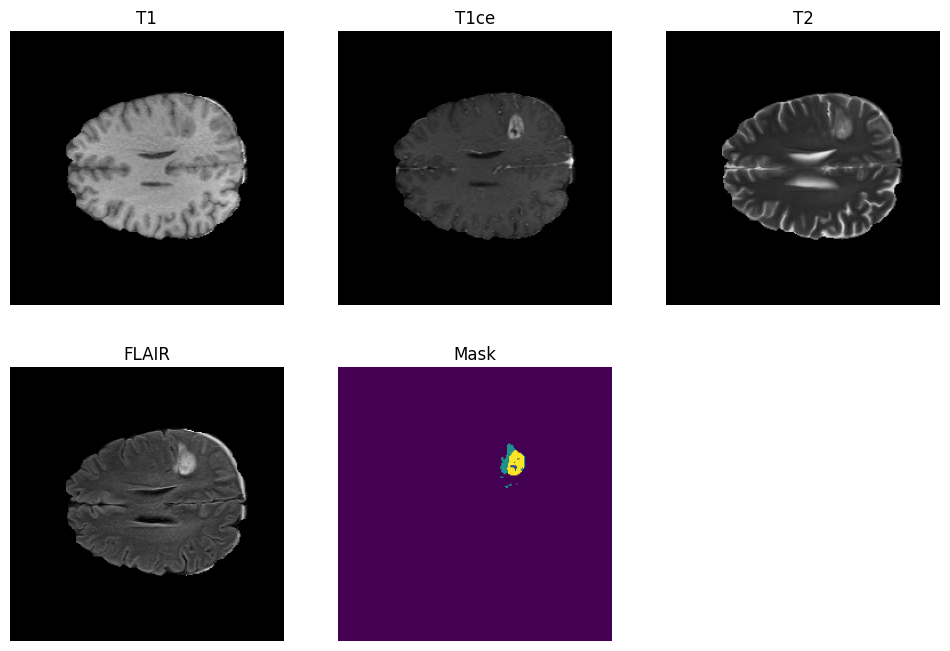

In [9]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(scaled_test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')
plt.axis('off')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(scaled_test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')
plt.axis('off')

# T2
plt.subplot(2, 3, 3)
plt.imshow(scaled_test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')
plt.axis('off')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(scaled_test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')
plt.axis('off')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.axis('off')

plt.show()

In [10]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 95


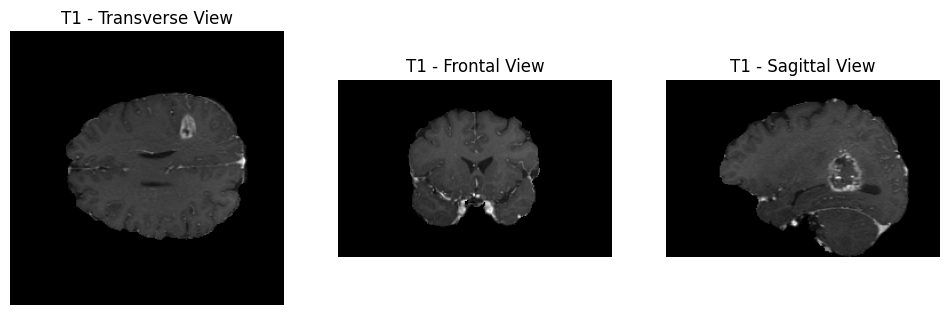

In [11]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')
plt.axis('off')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')
plt.axis('off')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.axis('off')

plt.show()

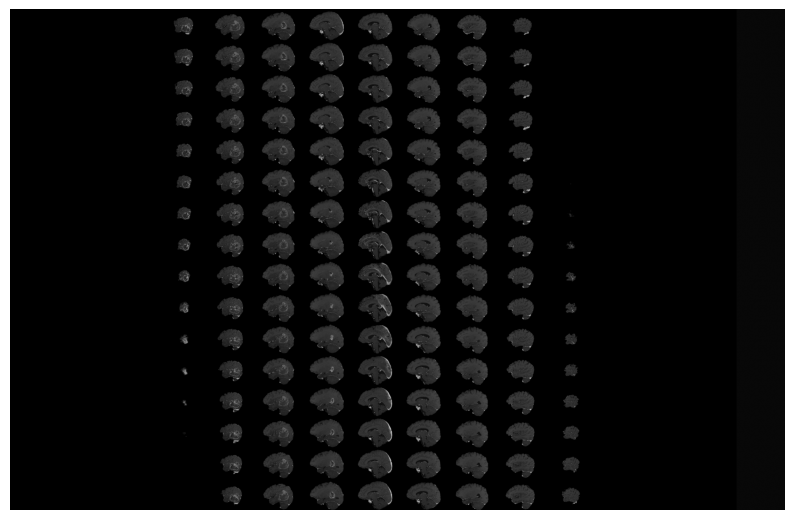

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');
plt.axis('off')
plt.show()

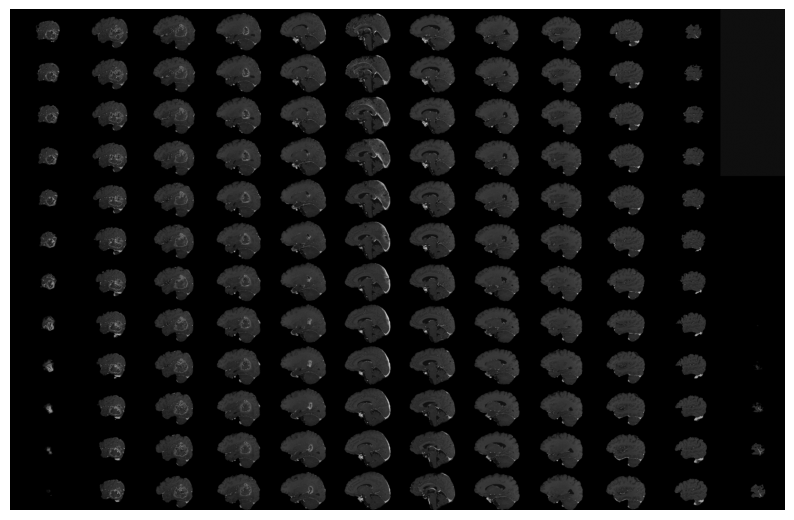

In [13]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');
plt.axis('off')
plt.show()

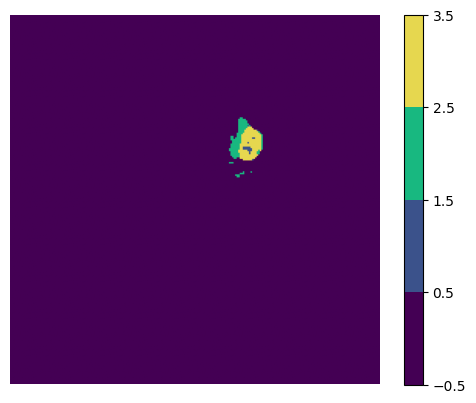

In [14]:
# Plotting the segmantation
cmap = mlt.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mlt.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.axis('off')
plt.show()

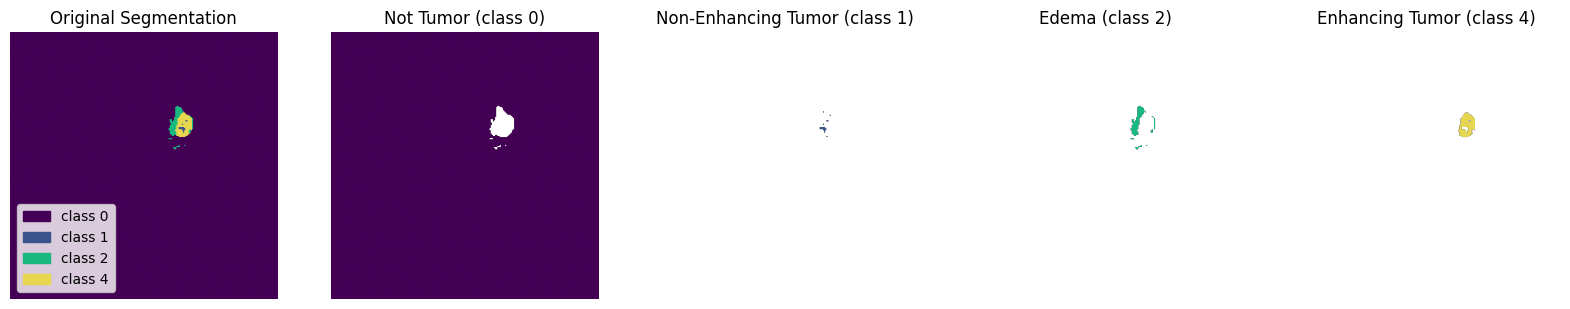

In [15]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')
ax[0].axis('off')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')
ax[1].axis('off')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')
ax[2].axis('off')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')
ax[3].axis('off')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')
ax[4].axis('off')

plt.show()

In [16]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(training_data_path) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

len(train_and_test_ids)

369

In [17]:
if 'BraTS20_Training_355' in train_and_test_ids:
    print('present')

present


In [18]:
x = train_and_test_ids.remove('BraTS20_Training_355')
if 'BraTS20_Training_355' in train_and_test_ids:
    print('present')

## 2.2 Splitting dataset into train, test and validation set

In [19]:
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [20]:
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 249
Validation length: 74
Test length: 45


# 3. Data Generator

In [21]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [22]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        super().__init__()
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(training_data_path, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

# 4. Preparing data & Displaying Some Images

In [23]:
training_generator = DataGenerator(train_ids)
validation_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

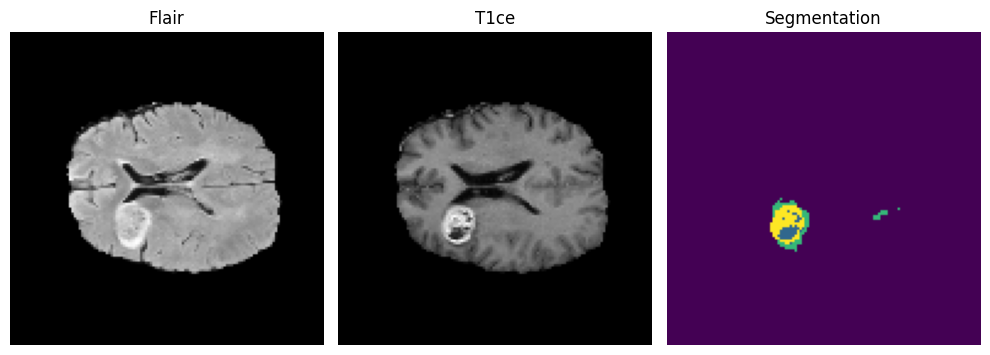

In [24]:
# function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1ce')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)
